In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io

# 1. Anomaly detection

### 1.1 Reading the data and plotting

In [2]:
os.listdir('Data/')

['ex8data1.mat',
 'ex8data2.mat',
 'ex8_movieParams.mat',
 'ex8_movies.mat',
 'movie_ids.txt']

In [3]:
data1 = scipy.io.loadmat('Data/ex8data1.mat')
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [4]:
X = data1['X']
Xval = data1['Xval']
yval = data1['yval']
yval = yval[:,0] #to work with arrays

(0.0, 30.0)

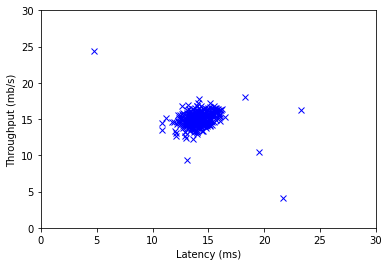

In [5]:
plt.plot(X[:,0],X[:,1],'bx')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.xlim(0, 30)
plt.ylim(0, 30)

### 1.2 Estimating parameters for a Gaussian

$$\mu = \frac{1}{m} \sum_{i=1} ^m x^{(i)}$$
$$\sigma ^2 = \frac{1}{m} \sum_{i=1} ^m (x^{(i)} - \mu).^2$$

In [6]:
def estimateGaussian(X):
    mu = np.mean(X, axis=0) #axis=0 because we take mean by rows
    sigma_square = np.std(X, axis=0)**2 #np.mean((X - mu )**2, axis=0)
    return mu, sigma_square

In [7]:
mu, s = estimateGaussian(X)
mu, s

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

$$P(x; \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\left(\frac{-(x - \mu)^2}{2\sigma^2}\right)$$

In [8]:
def GaussianProbability(X, mu, sigma_square):
    P = (1/np.sqrt(2*np.pi*sigma_square))*np.exp(- (X - mu)**2/ (2*sigma_square)) #P is m x n
    P = np.prod(P, axis=1) #P is m x 1 (P_1 x P_2 x ... x P_n)
    return P

In [9]:
P = GaussianProbability(X, mu, s)
P

array([6.47082850e-02, 5.03041697e-02, 7.24503459e-02, 5.03157451e-02,
       6.36849657e-02, 4.24583228e-02, 4.79094514e-02, 3.65111476e-02,
       1.86657981e-02, 5.06882606e-02, 2.65150875e-02, 8.47130185e-02,
       7.10473222e-02, 6.95531914e-02, 3.77788348e-02, 8.27029589e-02,
       8.77921221e-02, 8.68763043e-02, 6.91708642e-02, 9.73470177e-03,
       7.57066464e-02, 8.83768074e-02, 3.74100482e-02, 8.71375788e-02,
       4.12630362e-02, 2.48800242e-02, 7.90901300e-02, 7.59228904e-02,
       8.08257085e-02, 7.66395995e-02, 5.01173495e-02, 8.80498288e-02,
       6.17880844e-02, 5.96234469e-02, 2.09024063e-02, 4.57936991e-02,
       3.53418180e-02, 8.21286529e-02, 7.24325306e-02, 8.49788605e-02,
       6.41878342e-02, 6.64784465e-02, 8.37566936e-02, 8.57620375e-02,
       6.94628046e-02, 5.88478150e-02, 3.30652955e-02, 7.03092647e-02,
       7.77494497e-02, 3.59889069e-02, 7.34972804e-02, 7.56209579e-02,
       8.54690789e-02, 8.97861557e-02, 7.58702322e-02, 8.44453776e-02,
      

In [10]:
#Tengo X1, X2 pero como vectores pero necesito crear grillas
x = np.linspace(0,30,100)
y = np.linspace(0,30,100)
XX, YY = np.meshgrid(x, y)

In [11]:
X_long = np.stack((XX.flatten(), YY.flatten()), axis=1)
X_long.shape
Z = GaussianProbability(X_long, mu, s)
ZZ = np.reshape(Z, XX.shape)
ZZ.shape

(100, 100)

In [12]:
np.min(P)

1.181209116896769e-23

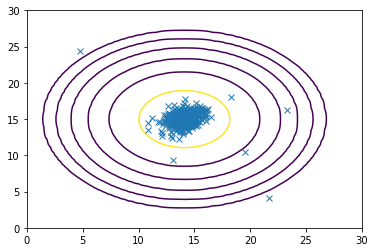

In [13]:
plt.plot(X[:,0], X[:,1], 'x')
plt.contour(XX, YY, ZZ, levels = 1) 
plt.contour(XX, YY, ZZ, levels = 10**np.linspace(-20,-3,6)) 

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

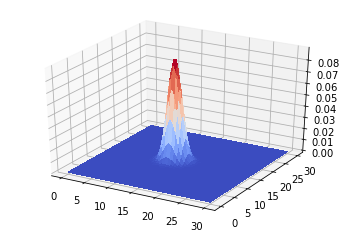

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(XX, YY, ZZ, cmap=cm.coolwarm, linewidth=0, antialiased=False)

### 1.3 Selecting the threshold, $\varepsilon$

In [16]:
pval = GaussianProbability(X, mu, s)

In [17]:
def selectThreshold(pval, yval):
    '''
    yval is the label 0/1 of the cross validation set
    y = 1 anomalous example
    y = 0 normal example
    '''
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    stepsize = (np.max(pval) - np.min(pval)) / 1000
    
    for epsilon in np.arange(np.min(pval),np.max(pval),stepsize): #len(np.arange(np.min(pval),np.max(pval),stepsize) = 1000
        #1. predict y using the GuassianProbability
        y = np.where(pval < epsilon, 1, 0) #where pval <= epsilon, then predict 1 (anomalous), else (p > epsilon), then predict 0
        #2. compute the F1 score
        #compute true positive tp, false positive fp and false negative fn
        tp = np.count_nonzero((y == 1) & (yval == 1))
        fp = np.count_nonzero((y == 1) & (yval == 0))
        fn = np.count_nonzero((y == 0) & (yval == 1))
        
        #compute precision and recall
        if (tp + fp) > 0:
            prec = tp / (tp + fp)
            rec = tp / (tp + fn)
            #compute F1 score
            F1 = (2*prec*rec) / (prec + rec)
        else:
            F1 = 0
            
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

In [18]:
#find best epsilon (that maximize F1 score)
epsilon, F1_score = selectThreshold(pval, yval)
epsilon, F1_score 

(8.986095083415362e-05, 0.8)

In [19]:
#find the outliers using the epsilon find above
outliers = np.where(P <= epsilon)
outliers

(array([300, 301, 303, 304, 305, 306], dtype=int64),)

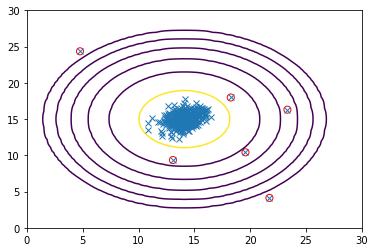

In [20]:
plt.plot(X[:,0], X[:,1], 'x')
plt.contour(XX, YY, ZZ, levels = 1) 
plt.contour(XX, YY, ZZ, levels = 10**np.linspace(-20,-3,6)) 
plt.scatter(X[outliers, 0], X[outliers, 1], facecolors='none', edgecolors='r', s=50);

### 1.4 High dimensional dataset

In [21]:
data2 = scipy.io.loadmat('Data/ex8data2.mat')
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [22]:
X = data2['X']
Xval = data2['Xval']
yval = data2['yval']
yval = yval[:,0] #convert m x 1 into (m, ) an array

In [23]:
# how the number of variables is 11, then doesn't have sense plot 
print(f'number training examples m = {X.shape[0]}, number of variables n = {X.shape[1]}')
print(f'number cross validation examples m = {Xval.shape[0]}')

number training examples m = 1000, number of variables n = 11
number cross validation examples m = 100


In [24]:
# Fit mu and sigma
mu, sigma_square = estimateGaussian(X)
mu, sigma_square

(array([  4.93940034,  -9.63726819,  13.81470749, -10.4644888 ,
         -7.95622922,  10.19950372,  -6.01940755,   7.96982896,
         -6.2531819 ,   2.32451289,   8.47372252]),
 array([60.97489373, 53.20572186, 58.51546272, 84.20403725, 65.26859177,
        89.57487757, 55.63349911, 87.16233783, 29.62926829, 70.7852052 ,
        50.50356719]))

In [25]:
#Cross validation
pval = GaussianProbability(Xval, mu, sigma_square)

In [26]:
#Find epsilon that maximize F1 score
epsilon, F1_score = selectThreshold(pval, yval)
epsilon, F1_score

(1.377228890761357e-18, 0.6153846153846154)

In [27]:
#Find outliers
P = GaussianProbability(X, mu, sigma_square)
outliers = np.where(P < epsilon)[0]
number_anomalies = outliers.shape[0]
print(f'There are {number_anomalies} in dataset 2')

There are 117 in dataset 2


# 2. Recommender Systems

In [28]:
moviesParams = scipy.io.loadmat('Data/ex8_movieParams.mat')
moviesParams.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [29]:
X = moviesParams['X']
Theta = moviesParams['Theta']
num_users = moviesParams['num_users'][0][0]
num_movies = moviesParams['num_movies'][0][0]
num_features = moviesParams['num_features'][0][0]
print(f'number of movies {num_movies}, number of features {num_features}, number of users {num_users}')

number of movies 1682, number of features 10, number of users 943


### 2.1 Movie ratings dataset

In [30]:
movies = scipy.io.loadmat('Data/ex8_movies.mat')
movies.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [31]:
Y = movies['Y']
R = movies['R']

In [32]:
Y[0,:] #the first movie (Toy story) has 943 users, but hasn't been evaluated by all users.
        #How many users has been rated Toy story?

array([5, 4, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0, 3, 0, 1, 5, 4, 5, 0, 3, 5, 0,
       5, 0, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 4, 5, 5, 4,
       5, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 4, 5, 5, 2, 0, 0, 2, 3, 4, 3, 3,
       3, 0, 0, 4, 0, 4, 2, 0, 4, 0, 5, 0, 4, 0, 4, 4, 4, 2, 0, 0, 0, 0,
       5, 0, 0, 4, 5, 4, 5, 5, 4, 0, 4, 0, 3, 3, 0, 0, 0, 4, 0, 4, 4, 0,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 0, 3, 4, 0, 0, 4, 0, 5, 4, 0,
       0, 5, 0, 0, 3, 4, 0, 0, 3, 0, 0, 4, 3, 0, 0, 4, 0, 4, 5, 0, 0, 0,
       0, 0, 5, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 3, 0, 0,
       3, 4, 0, 0, 3, 4, 0, 4, 0, 0, 0, 0, 5, 0, 0, 0, 4, 4, 0, 0, 0, 4,
       1, 5, 3, 3, 3, 2, 0, 0, 0, 0, 5, 5, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0,
       0, 4, 4, 0, 0, 0, 0, 0, 0, 5, 3, 4, 0, 3, 4, 0, 0, 0, 0, 0, 0, 4,
       4, 4, 0, 4, 4, 3, 4, 4, 4, 5, 5, 3, 0, 5, 0, 0, 0, 0, 0, 3, 5, 0,
       5, 0, 0, 3, 0, 0, 3, 0, 0, 4, 4, 5, 4, 0, 3, 4, 0, 0, 0, 0, 0, 4,
       5, 0, 3, 5, 5, 4, 2, 5, 4, 5, 3, 5, 3, 0, 4,

In [33]:
print(f'rating mean of Toy Story: {np.mean(Y[0,:])}')

rating mean of Toy Story: 1.8589607635206786


In [34]:
#Recall that the rating is between 1-5, when there is a 0, it's because there isn't rating of user j
print(f'rating mean of Toy Story: {np.mean(Y[0,Y[0,:] >= 1])}')

rating mean of Toy Story: 3.8783185840707963


### 2.2 Collaborative filtering learning algorithm

$$\displaystyle{J(x^{(1)},\ldots,x^{(n_m)},\theta^{(1)}, \ldots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j): R(i,j)=1} (\theta ^{(j)} \cdot x^{(i)} - y^{(i,j)})^2}$$

#### 2.2.1 Collaborative filtering cost function

In [35]:
X.shape

(1682, 10)

In [36]:
X.flatten().shape

(16820,)

In [37]:
Theta.shape

(943, 10)

In [38]:
Theta.flatten().shape

(9430,)

In [39]:
# unroll
params = np.hstack((X.flatten(), Theta.flatten())) #np.concatenate((X.flatten(), Theta.flatten()))
params.shape

(26250,)

In [40]:
np.reshape(params[0:num_movies*num_features], (num_movies, num_features)).shape

(1682, 10)

In [41]:
np.reshape(params[num_movies*num_features:], (num_users, num_features)).shape

(943, 10)

In [42]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda=0):
    # Unfold the U and W matrices from params
    X = np.reshape(params[0:num_movies*num_features], (num_movies, num_features))
    Theta = np.reshape(params[num_movies*num_features:], (num_users, num_features))
    
    J = 0.5*np.sum(R*(X @ Theta.T - Y)**2) #movies  x number of features
    return J

In [43]:
#Verify the result
num_users = 4
num_movies = 5
num_features = 3
X = X[0:num_movies, 0:num_features]
Theta = Theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]
J = cofiCostFunc(np.hstack((X.flatten(), Theta.flatten())), Y, R, num_users, num_movies, num_features, 0)
print(f'Cost at loaded parameters: {J} (this value should be about 22.22)')

Cost at loaded parameters: 22.224603725685675 (this value should be about 22.22)


In [44]:
i = 0
k = 0
j=0
#np.sum((R[i,:]*(X[i,:] @ Theta.T - Y[i,:])) * Theta[:,k]) 
#X[:,k] * (R[:,j]*(X @ Theta[j,:] - Y[:,j]))

#### 2.2.2 Collaborative filtering gradient

$$
\begin{array}{rcl}
\frac{\partial J}{\partial x_k ^{(i)}} & = & \sum_{j: r(i,j)=1} (\theta ^j \cdot x^{(i)} - y^{(i,j)}) \theta_k ^{(j)} \\
\frac{\partial J}{\partial \theta_k ^{(j)}} & = & \sum_{i: r(i,j)=1} (\theta ^j \cdot x^{(i)} - y^{(i,j)}) x_k ^{(i)}
\end{array}
$$

In [45]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda=0):
    # Unfold the U and W matrices from params
    X = np.reshape(params[0:num_movies*num_features], (num_movies, num_features))
    Theta = np.reshape(params[num_movies*num_features:], (num_users, num_features))
    
    #cost function
    J = 0.5*np.sum(R*(X @ Theta.T - Y)**2) #movies  x number of features
    
    #cost gradient
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    M = R*(X @ Theta.T - Y)
    
    for i in np.arange(num_movies):
        X_grad[i,:] = M[i,:] @ Theta 
    for j in np.arange(num_users):
        Theta_grad[j,:] = X.T @ M[:,j]
        
#     for i in np.arange(num_movies):
#         for k in np.arange(num_features):
#             X_grad[i,k] = np.sum((R[i,:]*(X[i,:] @ Theta.T - Y[i,:])) * Theta[:,k]) 
#     for j in np.arange(num_users):
#         for k in np.arange(num_features):
#             Theta_grad[j,k] = np.sum((R[:,j]*(X @ Theta[j,:] - Y[:,j]))*X[:,k]) 
    
    grad = np.concatenate((X_grad.flatten(), Theta_grad.flatten()))
    return J, grad

In [46]:
def computeNumericalGradient(theta, Y, R, num_users, num_movies, num_features, Lambda=0):
    numgrad = np.zeros(theta.shape[0])
    perturb = np.zeros(theta.shape[0])
    epsilon = 1e-4
    for p in np.arange(theta.shape[0]):
        # Set perturbation vector
        perturb[p] = epsilon
        loss1,_ = cofiCostFunc(theta - perturb, Y, R, num_users, num_movies, num_features, Lambda)
        loss2,_ = cofiCostFunc(theta + perturb, Y, R, num_users, num_movies, num_features, Lambda)
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2*epsilon)
        perturb[p] = 0
    return numgrad

In [47]:
def checkCostFunction(Lambda=0):
    # Create small problem
    X_t = np.random.randn(4, 3)
    Theta_t = np.random.randn(5, 3)

    # Zap out most entries
    Y = X_t @ Theta_t.T
    Y[np.random.randn(Y.shape[0], Y.shape[1]) > 0.5] = 0 #np.where(np.random.randn(Y.shape) <= 0.5, Y, 0)
    
    R = np.zeros(Y.shape)
    R[Y != 0] = 1

    # Run Gradient Checking
    X = np.random.randn(X_t.shape[0], X_t.shape[1])
    Theta = np.random.randn(Theta_t.shape[0], Theta_t.shape[1])
    num_users = Y.shape[1] 
    num_movies = Y.shape[0] 
    num_features = Theta_t.shape[1]
    
    
    cost, grad = cofiCostFunc(np.concatenate((X.flatten(), Theta.flatten())),  Y, R, num_users, num_movies, num_features, Lambda)
    params = np.concatenate((X.flatten(), Theta.flatten())) 
    numgrad = computeNumericalGradient(params, Y, R, num_users, num_movies, num_features, Lambda)
    print(f'grad = {grad}')
    print(f'numgrad = {numgrad}')
    
    print('The above two columns you get should be very similar. Left-Your Numerical Gradient, Right-Analytical Gradient')
    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print(f'If your cost function implementation is correct, then the relative difference will be small (less than 1e-9). Relative Difference: {diff}')
    return grad, numgrad, diff

In [48]:
grad, numgrad, diff = checkCostFunction()
diff

grad = [ 4.71412979  2.92618869  7.48974312 -4.8220762   0.37258102  4.70726096
 -0.49752659 -0.21211444 -0.94328807 -2.82617341  0.66448132 -3.6506563
  0.92645429 -0.79209937 -1.66102621  2.26054157  0.69103782 -2.38999967
  1.22667303 -1.62462118 -5.51725882 -3.62279579  1.17537018  0.15125565
 -2.25198664  2.4007701  -2.898366  ]
numgrad = [ 4.71412979  2.92618869  7.48974312 -4.8220762   0.37258102  4.70726096
 -0.49752659 -0.21211444 -0.94328807 -2.82617341  0.66448132 -3.6506563
  0.92645429 -0.79209937 -1.66102621  2.26054157  0.69103782 -2.38999967
  1.22667303 -1.62462118 -5.51725882 -3.62279579  1.17537018  0.15125565
 -2.25198664  2.4007701  -2.898366  ]
The above two columns you get should be very similar. Left-Your Numerical Gradient, Right-Analytical Gradient
If your cost function implementation is correct, then the relative difference will be small (less than 1e-9). Relative Difference: 1.6407797536551175e-12


1.6407797536551175e-12

#### 2.2.3 Regularized cost function

$$\displaystyle{J(x^{(1)},\ldots,x^{(n_m)},\theta^{(1)}, \ldots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j): R(i,j)=1} (\theta ^{(j)} \cdot x^{(i)} - y^{(i,j)})^2}
+ \frac{\lambda}{2} \sum_{j=1} ^{n_u} \sum_{k=1} ^n (\theta_k ^{(j)})^2
+ \frac{\lambda}{2} \sum_{i=1} ^{n_m} \sum_{k=1} ^n (x_k ^{(i)})^2
$$

In [49]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    # Unfold the U and W matrices from params
    X = np.reshape(params[0:num_movies*num_features], (num_movies, num_features))
    Theta = np.reshape(params[num_movies*num_features:], (num_users, num_features))
    
    #cost function
    reg1 = 0.5*Lambda*np.linalg.norm(X)**2
    reg2 = 0.5*Lambda*np.linalg.norm(Theta)**2
    J = 0.5*np.sum(R*(X @ Theta.T - Y)**2) + reg1 + reg2 #movies  x number of features
    
    #cost gradient
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    M = R*(X @ Theta.T - Y)
    
    for i in np.arange(num_movies):
        X_grad[i,:] = M[i,:] @ Theta 
    for j in np.arange(num_users):
        Theta_grad[j,:] = X.T @ M[:,j]
        
#     for i in np.arange(num_movies):
#         for k in np.arange(num_features):
#             X_grad[i,k] = np.sum((R[i,:]*(X[i,:] @ Theta.T - Y[i,:])) * Theta[:,k]) 
#     for j in np.arange(num_users):
#         for k in np.arange(num_features):
#             Theta_grad[j,k] = np.sum((R[:,j]*(X @ Theta[j,:] - Y[:,j]))*X[:,k]) 
    
    grad = np.concatenate((X_grad.flatten(), Theta_grad.flatten()))
    return J, grad

In [50]:
J,_ = cofiCostFunc(np.hstack((X.flatten(), Theta.flatten())), Y, R, num_users, num_movies, num_features, 1.5)         
print(f'Cost at loaded parameters (lambda = 1.5) {J} (this value should be about 31.34)')

Cost at loaded parameters (lambda = 1.5) 31.344056244274217 (this value should be about 31.34)


#### 2.2.4 Regularized gradient

$$
\begin{array}{rcl}
\frac{\partial J}{\partial x_k ^{(i)}} & = & \sum_{j: r(i,j)=1} (\theta ^j \cdot x^{(i)} - y^{(i,j)}) \theta_k ^{(j)} + \lambda x_k ^{(i)}\\
\frac{\partial J}{\partial \theta_k ^{(j)}} & = & \sum_{i: r(i,j)=1} (\theta ^j \cdot x^{(i)} - y^{(i,j)}) x_k ^{(i)} + \lambda \theta_k ^{(j)}
\end{array}
$$

In [51]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    # Unfold the U and W matrices from params
    X = np.reshape(params[0:num_movies*num_features], (num_movies, num_features))
    Theta = np.reshape(params[num_movies*num_features:], (num_users, num_features))
    
    #cost function
    reg1 = 0.5*Lambda*np.linalg.norm(X)**2
    reg2 = 0.5*Lambda*np.linalg.norm(Theta)**2
    J = 0.5*np.sum(R*(X @ Theta.T - Y)**2) + reg1 + reg2 #movies  x number of features
    
    #cost gradient
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    M = R*(X @ Theta.T - Y)
    
    for i in np.arange(num_movies):
        X_grad[i,:] = (M[i,:] @ Theta) + Lambda*X[i,:]
    for j in np.arange(num_users):
        Theta_grad[j,:] = (X.T @ M[:,j]) + Lambda*Theta[j,:]
        
#     for i in np.arange(num_movies):
#         for k in np.arange(num_features):
#             X_grad[i,k] = np.sum((R[i,:]*(X[i,:] @ Theta.T - Y[i,:])) * Theta[:,k]) 
#     for j in np.arange(num_users):
#         for k in np.arange(num_features):
#             Theta_grad[j,k] = np.sum((R[:,j]*(X @ Theta[j,:] - Y[:,j]))*X[:,k]) 
    
    grad = np.concatenate((X_grad.flatten(), Theta_grad.flatten()))
    return J, grad

In [52]:
print('Checking Gradients (with regularization) ... ')
#  Check gradients by running checkNNGradients
grad, numgrad, diff = checkCostFunction(Lambda=1.5)
diff

Checking Gradients (with regularization) ... 
grad = [  3.00779335   1.89958539  -6.13209139 -12.4602764    8.83725984
  20.09268771  -4.95063167   1.1709904    4.40546275   3.30505175
   9.11889746 -10.94637061   0.66173905  10.75467044  -8.94482794
  -0.60667418   2.53042031  -2.34343095  -3.88403224  -0.51990412
   6.55917341  -1.85563421   6.06206257   8.13046631  -0.98922266
   3.40704927   7.91094137]
numgrad = [  3.00779335   1.89958539  -6.13209139 -12.4602764    8.83725984
  20.09268771  -4.95063167   1.1709904    4.40546275   3.30505175
   9.11889746 -10.94637061   0.66173905  10.75467044  -8.94482794
  -0.60667418   2.53042031  -2.34343095  -3.88403224  -0.51990412
   6.55917341  -1.85563421   6.06206257   8.13046631  -0.98922266
   3.40704927   7.91094137]
The above two columns you get should be very similar. Left-Your Numerical Gradient, Right-Analytical Gradient
If your cost function implementation is correct, then the relative difference will be small (less than 1e-9). R

3.146238871252672e-12

### 2.3 Learning movie recommendations

In [53]:
# np.loadtxt(, usecols=2)
def loadMovieList():
    movie_list = []
    f = open('Data/movie_ids.txt')
    lines = f.readlines()
    for line in lines:
        strings_in_line = line.rstrip() #remove spaces
        strings_in_line_split = strings_in_line.split(' ')
        strings_in_line = strings_in_line_split[1:] #not consider the index
        movie_name = ' '.join(strings_in_line)
        movie_list.append(movie_name)
    return movie_list

In [54]:
loadMovieList()

['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Twelve Monkeys (1995)',
 'Babe (1995)',
 'Dead Man Walking (1995)',
 'Richard III (1995)',
 'Seven (Se7en) (1995)',
 'Usual Suspects, The (1995)',
 'Mighty Aphrodite (1995)',
 'Postino, Il (1994)',
 "Mr. Holland's Opus (1995)",
 'French Twist (Gazon maudit) (1995)',
 'From Dusk Till Dawn (1996)',
 'White Balloon, The (1995)',
 "Antonia's Line (1995)",
 'Angels and Insects (1995)',
 'Muppet Treasure Island (1996)',
 'Braveheart (1995)',
 'Taxi Driver (1976)',
 'Rumble in the Bronx (1995)',
 'Birdcage, The (1996)',
 'Brothers McMullen, The (1995)',
 'Bad Boys (1995)',
 'Apollo 13 (1995)',
 'Batman Forever (1995)',
 'Belle de jour (1967)',
 'Crimson Tide (1995)',
 'Crumb (1994)',
 'Desperado (1995)',
 'Doom Generation, The (1995)',
 'Free Willy 2: The Adventure Home (1995)',
 'Mad Love (1995)',
 'Nadja (1994)',
 'Net, The (1995

In [55]:
movieList = loadMovieList()

#  Initialize my ratings
my_ratings = np.zeros((1682,1))

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0,0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97,0] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6,0] = 3
my_ratings[11,0]= 5
my_ratings[53,0] = 4
my_ratings[63,0]= 5
my_ratings[65,0]= 3
my_ratings[68,0] = 5
my_ratings[182,0] = 4
my_ratings[225,0] = 5
my_ratings[354,0]= 5

print('New user ratings:')
for i in range(len(my_ratings)):
    if my_ratings[i,0] > 0 :
        print(f'Rated {my_ratings[i,0]} for {movieList[i]}')

New user ratings:
Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0 for Alien (1979)
Rated 5.0 for Die Hard 2 (1990)
Rated 5.0 for Sphere (1998)


#### 2.3.1 Recommendations

In [56]:
print('Training collaborative filtering...')

#  Load data
movies = scipy.io.loadmat('Data/ex8_movies.mat')

Y = movies['Y']
R = movies['R']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix
Y = np.concatenate((my_ratings, Y), axis=1)

Training collaborative filtering...


In [57]:
def normalizeRatings(Y, R):
#NORMALIZERATINGS Preprocess data by subtracting mean rating for every 
#movie (every row)
#   [Ynorm, Ymean] = NORMALIZERATINGS(Y, R) normalized Y so that each movie
#   has a rating of 0 on average, and returns the mean rating in Ymean.
    m, n = Y.shape
    Ymean = np.zeros((m, 1))
    Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = np.argwhere(R[i, :] == 1)
        Ymean[i] = Y[i, idx].mean()
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
    return Ynorm, Ymean

In [58]:
R = np.concatenate((np.where(my_ratings > 0, 1, 0), R), axis=1)

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)
Ynorm.mean()

5.462286541176089e-19

In [59]:
#  Useful Values
num_movies = Y.shape[0]
num_users = Y.shape[1]
num_features = 10

In [60]:
# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate((X.flatten(), Theta.flatten()))

# Set options for fmincg
#options = optimset('GradObj', 'on', 'MaxIter', 100)

# Set Regularization
Lambda = 10
result = scipy.optimize.minimize(cofiCostFunc, initial_parameters, args=(Ynorm, R, num_users, num_movies, num_features,Lambda), method='CG', jac=True, options={'maxiter': 100})
theta = result.x
result

     fun: 38952.356976865965
     jac: array([-0.08063778, -0.04705353, -0.02685975, ..., -0.00528718,
       -0.00208169, -0.00898501])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 149
     nit: 100
    njev: 149
  status: 1
 success: False
       x: array([ 0.73958812,  0.52116004,  0.40328322, ..., -0.48325478,
       -0.31080091,  0.02296173])

In [61]:
# Unfold the returned theta back into U and W
X = np.reshape(theta[0:num_movies*num_features], (num_movies, num_features))
Theta = np.reshape(theta[num_movies*num_features:], (num_users, num_features))

print('Recommender system learning completed.')

Recommender system learning completed.


In [62]:
#predictions
#TOY Story -> y[0,0] = 4
X[0,:] @ Theta[0,:] + Ymean[0,0]

4.00050144834473

In [63]:
Y.shape

(1682, 944)

In [64]:
predictions = X @ Theta.T 
my_preds = (predictions + Ymean)[:,-1]
my_preds.shape

(1682,)

In [65]:
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10]

array([5.35219691, 5.13501964, 5.00000337, 5.00000251, 5.00000185,
       5.00000183, 5.00000126, 5.00000098, 5.00000007, 4.99999969])

In [66]:
idx = np.argsort(my_preds, axis=0)[::-1]
idx
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movieList[j]))

Top 10 movie predictions:
Predicted rating of 5.352196910470282 for movie Scream (1996).
Predicted rating of 5.135019643802482 for movie Seven (Se7en) (1995).
Predicted rating of 5.000003366382519 for movie Aiqing wansui (1994).
Predicted rating of 5.0000025081680635 for movie Star Kid (1997).
Predicted rating of 5.000001848465316 for movie They Made Me a Criminal (1939).
Predicted rating of 5.000001825364127 for movie Santa with Muscles (1996).
Predicted rating of 5.0000012584612605 for movie Great Day in Harlem, A (1994).
Predicted rating of 5.000000982509244 for movie Prefontaine (1997).
Predicted rating of 5.000000066117046 for movie Saint of Fort Washington, The (1993).
Predicted rating of 4.999999692406174 for movie Entertaining Angels: The Dorothy Day Story (1996).
